In [1]:
### Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import helper as my

import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
# tf.compat.v1.enable_eager_execution()
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import pairwise
from sklearn.cluster import KMeans

from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import mean_squared_error

### Get the data
NBAdata, draftData = my.getData()

In [2]:
### define the columns we want
clusteringCols = ['FT%', '3P%', 'eFG%', 'ORB%', 'DRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'USG%', 'OWS', 'DWS', 
                  'FTA', '3PA', 'PTS', 'PF', 'MP_per_PF', 'FTA_per_FGA', 'MP_per_3PA', 'PTS_per_FGA', 
                  'C', 'F', 'G', 'PPM', 'PPG', 'HEIGHT', 'WEIGHT']

x_cols = ['gamesPlayed', 'minutes', 'FT%', '3P%', 'SOS', 'PER', 'eFG%', 'ORB%', 'DRB%', 'AST%', 'TOV%', 
          'STL%', 'BLK%', 'USG%','OWS', 'DWS', 'FTA', 'FGA', 'MP', '3PA', 'PTS', 'PF', 'MP_per_PF', 'PPG', 
          'PPM','FTA_per_FGA', 'MP_per_3PA', 'PTS_per_FGA', "AST_per_TOV", 'ORtg', 'DRtg','awards','RSCI', 
          'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'SHUTTLE_RUN','THREE_QUARTER_SPRINT', 'STANDING_VERTICAL', 
          'MAX_VERTICAL','BENCH_PRESS', 'BODY_FAT', 'HAND_LENGTH', 'HAND_WIDTH', "didCombine", 
          'HEIGHT_W_SHOES', 'REACH', 'WEIGHT', 'WINGSPAN', 'C', 'F', 'G']
target = "WM"
allCols = list(dict.fromkeys(clusteringCols + x_cols)) # removes duplicates
draftOnlyCols = [col for col in allCols if col not in clusteringCols]


scaler = StandardScaler()
# scaler = MinMaxScaler()

scaledNBA, scaledDraft = NBAdata.copy(), draftData.copy()
scaledNBA[clusteringCols] = scaler.fit_transform(scaledNBA[clusteringCols])
scaledDraft[clusteringCols] = scaler.transform(scaledDraft[clusteringCols])
scaledDraft[draftOnlyCols] = scaler.fit_transform(scaledDraft[draftOnlyCols])

In [3]:
### Do the clustering
n_clusters =  3

fittedCluster = KMeans(n_clusters=n_clusters).fit(scaledNBA[clusteringCols].values)
scaledNBA['label'] = fittedCluster.labels_
scaledDraft['label'] = fittedCluster.predict(scaledDraft[clusteringCols].values, sample_weight=None)

In [4]:
# Create a function that will get features for all draftees for each team
metricCols = clusteringCols
metric = "euclidean"
metric_function = pairwise.distance_metrics()[metric]
n_players = 7
nba_features = ['dist_avg', "dist_std", "dist_dot_min", "dist_dot_WS", "min_dist", "label_count",
                #'label_dist_avg', "label_dist_std", "label_dist_dot_min", "label_dist_dot_WS", "label_min_dist"
               ]
def getTeamFeatures(draftee):
    draftYear = draftee["Year"]
    nbaYear = scaledNBA[scaledNBA["Year"]==draftYear-1]
    thisYearsTeams = nbaYear["Tm"].unique()
    preds = pd.DataFrame({"Team":thisYearsTeams})
    for col in nba_features: preds[col] = np.nan
    
    for i in range(len(preds)):
        nbaTeamName = preds["Team"].iloc[i]
        fullnbaTeam = nbaYear[nbaYear["Tm"]==nbaTeamName].sort_values(by=["MP"])
        labelTeam = fullnbaTeam[fullnbaTeam['label']==draftee["label"]]
        teamSize, labelSize = len(fullnbaTeam), len(labelTeam)
        
        nbaTeam = fullnbaTeam.iloc[:n_players] if teamSize>=n_players else fullnbaTeam
        
        distances = np.array([metric_function(draftee[metricCols].to_numpy().reshape(1,-1), 
                                     nbaTeam[metricCols].iloc[i][metricCols].to_numpy().reshape(1,-1)).item()
                     for i in range(len(nbaTeam))])
        label_distances = np.array([metric_function(draftee[metricCols].to_numpy().reshape(1,-1), 
                                     labelTeam[metricCols].iloc[i][metricCols].to_numpy().reshape(1,-1)).item()
                     for i in range(len(labelTeam))])
        # Turn them into a feature vector
        preds.iloc[i,preds.columns.get_loc("dist_avg")] = np.mean(distances)
        preds.iloc[i,preds.columns.get_loc("dist_std")] = np.std(distances)
        preds.iloc[i,preds.columns.get_loc("dist_dot_min")] = np.dot(1./distances, nbaTeam["MP"].values)
        preds.iloc[i,preds.columns.get_loc("dist_dot_WS")] = np.dot(1./distances, nbaTeam["MP"].values)
        preds.iloc[i,preds.columns.get_loc("min_dist")] = np.min(distances)
        
        preds.iloc[i,preds.columns.get_loc("label_count")] = labelSize/teamSize
        if False: #len(label_distances) != 0:
            preds.iloc[i,preds.columns.get_loc("label_dist_avg")] = np.mean(label_distances)
            preds.iloc[i,preds.columns.get_loc("label_dist_std")] = np.std(label_distances)
            preds.iloc[i,preds.columns.get_loc("label_dist_dot_min")] = np.dot(1./label_distances,
                                                                               labelTeam["MP"].values)
            preds.iloc[i,preds.columns.get_loc("label_dist_dot_WS")] = np.dot(1./label_distances, 
                                                                              labelTeam["MP"].values)
            preds.iloc[i,preds.columns.get_loc("label_min_dist")] = np.min(label_distances)
        
    # Do some quick mean imputation if there are missing values
    for col in nba_features:
        preds[col] = preds[col].fillna(np.mean(preds[col]))
        
    return preds
        
# Create a dictionary containing {draftee name:team features df}
# teamFeatures = {}
# for i in range(len(scaledDraft)):
#     draftee = scaledDraft.iloc[i]
#     drafteeName = draftee["Player"]
#     teamFeatures[drafteeName] = getTeamFeatures(draftee)
    
#     # Do some mean imputation on the missing values
    
#     print("{}/{} completed!".format(i+1, len(scaledDraft)))

teamFeatures = np.load("/home/nrowe/Thesis/Model/teamFeatures_1.npy", allow_pickle=True).tolist()

In [5]:
# Save these feautres as a dictionary
# np.save('teamFeatures_1.npy', teamFeatures)

In [6]:
# Scale these new features
allTeamFeatures = [0 for i in range(len(teamFeatures.keys()))]
# Combine them to create one scaler
for i, key in enumerate(teamFeatures.keys()): 
    allTeamFeatures[i] = teamFeatures[key]
    
allTeamFeatures = pd.concat(allTeamFeatures)
scaler = StandardScaler()
scaler.fit(allTeamFeatures[nba_features])

for i, key in enumerate(teamFeatures.keys()): 
    teamFeatures[key][nba_features] = scaler.transform(teamFeatures[key][nba_features])

# Change what our training subset looks like 
allCols = list(dict.fromkeys(allCols)) # removes duplicate
trainingCols = allCols + nba_features

In [7]:
# Add the actual features (for training the model) to the overall dataset
for col in nba_features: scaledDraft[col] = np.nan
for i in range(len(scaledDraft)):
    key = scaledDraft.iloc[i]["Player"]
    tm = scaledDraft.iloc[i]["Tm"]
    featuresDF = teamFeatures[key]
    for col in nba_features:
        value = featuresDF[featuresDF["Team"]==tm][col]
        scaledDraft.iloc[i, scaledDraft.columns.get_loc(col)] = featuresDF[featuresDF["Team"]==tm][col].values[0]

In [8]:
## NEURAL NETWORK MODEL
def create_NN():
    N, epochs, batch_size = len(trainingCols), 20, 20
    def create_model():
        model = Sequential()
        model.add(Dense(N, input_dim=N, kernel_initializer='normal', activation='sigmoid'))
        model.add(Dense(1, kernel_initializer='normal'))
        # Compile model
        model.compile(loss='mean_squared_error', optimizer="Adam")
        return model
    return KerasRegressor(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)


## RANDOM FOREST MODEL
def create_RF():
    params = {"n_estimators":100, "n_jobs":-1}
    return RandomForestRegressor(**params)

In [9]:
## Split the data into X and Y
draftX, draftY = scaledDraft[trainingCols], scaledDraft[target]

## Set up oversampling (only affects draft data I think)
oversampledX, oversampledY = draftX.copy(), draftY.copy()
highValue = 3
highDraftX, highDraftY = oversampledX[oversampledY > highValue], oversampledY[oversampledY > highValue]
lowValue = 0.1
lowDraftX, lowDraftY = oversampledX[oversampledY < lowValue], oversampledY[oversampledY < lowValue]
middleRowNum = len(draftX) - len(highDraftX) - len(lowDraftX)

# Number of samples is equal to size of subset
for i in range(len(highDraftX)*2):
    addRow = np.random.randint(len(highDraftX))
    oversampledX = oversampledX.append(highDraftX.iloc[addRow])
    oversampledY = oversampledY.append(pd.Series(highDraftY.iloc[addRow], index=[highDraftY.index[addRow]]))
    
# for i in range(len(lowDraftX)):
# for i in range(middleRowNum):
for i in range(len(lowDraftX)):
    addRow = np.random.randint(len(lowDraftX))
    oversampledX = oversampledX.append(lowDraftX.iloc[addRow])
    oversampledY = oversampledY.append(pd.Series(lowDraftY.iloc[addRow], index=[lowDraftY.index[addRow]]))  

# oversampledX.reset_index(inplace=True, drop=True)
# oversampledY.reset_index(inplace=True, drop=True)

In [10]:
# Do the actual loop to get predicted values
loo = LeaveOneOut()
preds = pd.DataFrame(index=scaledDraft.index, columns=["WM_pred"])

model = create_NN()
for _, test_index in loo.split(draftX):

    # Split the data according to the oversampling
    # X_test, Y_test = draftX.loc[test_index[0]:test_index[0]], draftY.loc[test_index[0]:test_index[0]]
    X_test, Y_test = draftX.iloc[test_index[0]:test_index[0]+1], draftY.iloc[test_index[0]:test_index[0]+1]
    # X_test, Y_test = draftX.loc[test_index], draftY.loc[test_index]
    X_train = oversampledX.drop([test_index[0]], axis=0, inplace=False)
    Y_train = oversampledY.drop([test_index[0]], axis=0, inplace=False)
    
    # Make sure no occurances of test in training
    X_train = X_train[X_train.index!=X_test.index.values[0]]
    Y_train = Y_train[X_train.index!=X_test.index.values[0]]
    
    # Convert the input to tensors
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)
    old_X_test = X_test
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    
    # Generate the model
    model.fit(X_train, Y_train)
    preds["WM_pred"].iloc[test_index] = model.predict(X_test)
    
    # Now we use that trained model to make predictions on all of the team combinations
    key = scaledDraft.loc[test_index]["Player"].values[0]
    teamFeaturesDic = teamFeatures[key]
    teamFeaturesDic['WM_pred'] = np.nan

    targetColLoc = teamFeaturesDic.columns.get_loc("WM_pred")
    for i in range(len(teamFeaturesDic)):
        team = teamFeaturesDic.iloc[i]["Team"]
        teamData = teamFeaturesDic.iloc[i:i+1][nba_features]
        # Merge it with the other features
        for col in allCols: 
            teamData[col] = old_X_test[col].values[0]

        # Do the predictions
        teamData = tf.convert_to_tensor(teamData, dtype=tf.float32)
        teamFeaturesDic.iloc[i, targetColLoc] = model.predict(teamData)
        
    teamFeatures[key] = teamFeaturesDic
    
    print("{}/{} complete! ({})".format(test_index[0]+1, len(draftX), key))
    
scaledDraft = pd.concat([scaledDraft, preds], axis=1, sort=False)
datatypes = {"WM_pred":float}
scaledDraft = scaledDraft.astype(datatypes)

1/655 complete! (markellefultz)
2/655 complete! (lonzoball)
3/655 complete! (jaysontatum)
4/655 complete! (joshjackson)
5/655 complete! (deaaronfox)
6/655 complete! (jonathanisaac)
7/655 complete! (laurimarkkanen)
8/655 complete! (dennissmith)
9/655 complete! (zachcollins)
10/655 complete! (malikmonk)
11/655 complete! (lukekennard)
12/655 complete! (donovanmitchell)
13/655 complete! (bamadebayo)
14/655 complete! (justinpatton)
15/655 complete! (djwilson)
16/655 complete! (tjleaf)
17/655 complete! (johncollins)
18/655 complete! (harrygiles)
19/655 complete! (jarrettallen)
20/655 complete! (oganunoby)
21/655 complete! (tylerlydon)
22/655 complete! (calebswanigan)
23/655 complete! (kylekuzma)
24/655 complete! (tonybradley)
25/655 complete! (derrickwhite)
26/655 complete! (joshhart)
27/655 complete! (frankjackson)
28/655 complete! (davonreed)
29/655 complete! (frankmason)
30/655 complete! (ivanrabb)
31/655 complete! (jonahbolden)
32/655 complete! (semiojeleye)
33/655 complete! (jordanbell)

254/655 complete! (robertsacre)
255/655 complete! (kyrieirving)
256/655 complete! (derrickwilliams)
257/655 complete! (tristanthompson)
258/655 complete! (brandonknight)
259/655 complete! (kembawalker)
260/655 complete! (jimmerfredette)
261/655 complete! (klaythompson)
262/655 complete! (alecburks)
263/655 complete! (markieffmorris)
264/655 complete! (marcusmorris)
265/655 complete! (kawhileonard)
266/655 complete! (nikolavucevic)
267/655 complete! (imanshumpert)
268/655 complete! (chrissingleton)
269/655 complete! (tobiasharris)
270/655 complete! (nolansmith)
271/655 complete! (kennethfaried)
272/655 complete! (reggiejackson)
273/655 complete! (marshonbrooks)
274/655 complete! (jordanhamilton)
275/655 complete! (jajuanjohnson)
276/655 complete! (norriscole)
277/655 complete! (coryjoseph)
278/655 complete! (jimmybutler)
279/655 complete! (justinharper)
280/655 complete! (kylesingler)
281/655 complete! (shelvinmack)
282/655 complete! (tylerhoneycutt)
283/655 complete! (jordanwilliams)
2

507/655 complete! (hakimwarrick)
508/655 complete! (juliushodge)
509/655 complete! (naterobinson)
510/655 complete! (jarrettjack)
511/655 complete! (franciscogarcia)
512/655 complete! (lutherhead)
513/655 complete! (jasonmaxiell)
514/655 complete! (linaskleiza)
515/655 complete! (davidlee)
516/655 complete! (salimstoudamire)
517/655 complete! (danielewing)
518/655 complete! (ronnyturiaf)
519/655 complete! (travisdiener)
520/655 complete! (vonwafer)
521/655 complete! (braceywright)
522/655 complete! (ryangomes)
523/655 complete! (oriengreene)
524/655 complete! (dijonthompson)
525/655 complete! (alexacker)
526/655 complete! (bengordon)
527/655 complete! (devinharris)
528/655 complete! (joshchildress)
529/655 complete! (luoldeng)
530/655 complete! (rafaelaraujo)
531/655 complete! (andreiguodala)
532/655 complete! (lukejackson)
533/655 complete! (krishumphries)
534/655 complete! (kirksnyder)
535/655 complete! (jameernelson)
536/655 complete! (tonyallen)
537/655 complete! (kevinmartin)
538/

WM MSE: 2.4808586457894743


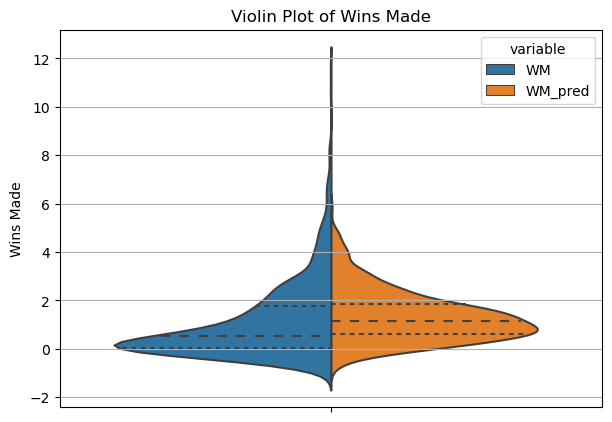

In [11]:
# Calculate some of the errors
print("WM MSE: {}".format(mean_squared_error(scaledDraft.loc[scaledDraft["WM"].isnull()==False]["WM"], 
                                             preds.loc[scaledDraft["WM"].isnull()==False]["WM_pred"], 
                                             squared=True)))

# Some plotting of these
import seaborn as sns

plt.figure(figsize=(7,5), dpi=100)
plt.title("Violin Plot of Wins Made")
plt.grid()
plotData = scaledDraft[["WM", "WM_pred"]].melt().assign(x="")
sns.violinplot(data=plotData, x="x", y="value", hue="variable", inner="quartile", split=True)
plt.ylabel("Wins Made")
plt.xlabel("")
plt.show()


In [12]:
# Define a function to grab the next best pick for a team
def getHighestPred(data, team):
    playerNames = data['Player']
    bestName, bestProj = None, -100
    for name in playerNames:
        playerProjs = teamFeatures[name]
        proj = playerProjs[playerProjs["Team"]==team]["WM_pred"].values[0]
        
        if proj > bestProj:
            bestName = name
    
    return bestName

# Create a mock draft to evaluate how many wins are gained
scaledDraft.rename(columns={"Pk":"overallPick"}, inplace=True)
simData = pd.DataFrame(columns=["team", "oldPick", "newPick", "year"])
ALL_TEAMS = scaledDraft["Tm"].unique()
for year in np.unique(scaledDraft["Year"]):
    if year > 2016:
        continue
    yearDraftData = scaledDraft[scaledDraft["Year"]==year]
    yearNBAData = scaledNBA[scaledNBA["Year"]==year]
    yearDraftData.sort_values(by=["overallPick"], inplace=True)
    picks, teams = yearDraftData["overallPick"].to_numpy(), yearDraftData["Tm"].to_numpy()
    picks, teams = picks[~pd.isnull(picks)], teams[~pd.isnull(picks)]
    
    for myTeam in ALL_TEAMS:
        print("YEAR: {}, TEAM: {}".format(year, myTeam))
        oldPicks = yearDraftData.loc[yearDraftData["Tm"]==myTeam]["Player"].to_numpy() # These are players
        myPicks = yearDraftData.loc[yearDraftData["Tm"]==myTeam]['overallPick'].to_numpy() # These are numbers
        alreadyPicked = []
        myActualPicks = []
        
        # Figure out what the new picks will be
        for pick in picks:
            avalPicks = yearDraftData[~yearDraftData.Player.isin(alreadyPicked)]
            if pick in myPicks:
                # Choose highest remaining target value
                # myPick = getHighestPred(avalPicks, myTeam)
                myPick = avalPicks.loc[avalPicks["WM_pred"]==max(avalPicks["WM_pred"])]["Player"].iloc[0]
                
                alreadyPicked.append(myPick)
                myActualPicks.append(myPick)
            else:
                minPick = min(avalPicks['overallPick'])
                theirPick = avalPicks.loc[avalPicks['overallPick']==minPick]["Player"].iloc[0]
                alreadyPicked.append(theirPick)
                
        if len(np.unique(myActualPicks))!=len(myActualPicks):
            print("ERROR")
            
        for i in range(len(myPicks)):
            teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
            teamSeries["year"] = year
            teamSeries["team"] = myTeam
            teamSeries["oldPick"] = oldPicks[i]
            teamSeries["newPick"] = myActualPicks[i]
            teamSeries['overallPick'] = myPicks[i]
            
            simData = simData.append(teamSeries, ignore_index=True)
            

YEAR: 2000, TEAM: PHI


<ipython-input-12-4fc66cc84f35>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will

YEAR: 2000, TEAM: LAL
YEAR: 2000, TEAM: BOS
YEAR: 2000, TEAM: PHO
YEAR: 2000, TEAM: SAC
YEAR: 2000, TEAM: ORL
YEAR: 2000, TEAM: MIN
YEAR: 2000, TEAM: DAL
YEAR: 2000, TEAM: CHO
YEAR: 2000, TEAM: DET
YEAR: 2000, TEAM: DEN
YEAR: 2000, TEAM: MIA
YEAR: 2000, TEAM: CHI
YEAR: 2000, TEAM: MIL
YEAR: 2000, TEAM: IND
YEAR: 2000, TEAM: ATL

<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu


YEAR: 2000, TEAM: POR
YEAR: 2000, TEAM: BRK
YEAR: 2000, TEAM: TOR
YEAR: 2000, TEAM: UTA
YEAR: 2000, TEAM: SAS
YEAR: 2000, TEAM: NOP
YEAR: 2000, TEAM: NYK
YEAR: 2000, TEAM: HOU
YEAR: 2000, TEAM: LAC
YEAR: 2000, TEAM: GSW
YEAR: 2000, TEAM: OKC
YEAR: 2000, TEAM: WAS
YEAR: 2000, TEAM: CLE


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2000, TEAM: MEM
YEAR: 2001, TEAM: PHI
YEAR: 2001, TEAM: LAL
YEAR: 2001, TEAM: BOS
YEAR: 2001, TEAM: PHO
YEAR: 2001, TEAM: SAC
YEAR: 2001, TEAM: ORL
YEAR: 2001, TEAM: MIN
YEAR: 2001, TEAM: DAL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2001, TEAM: CHO
YEAR: 2001, TEAM: DET
YEAR: 2001, TEAM: DEN
YEAR: 2001, TEAM: MIA
YEAR: 2001, TEAM: CHI
YEAR: 2001, TEAM: MIL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2001, TEAM: IND
YEAR: 2001, TEAM: ATL
YEAR: 2001, TEAM: POR
YEAR: 2001, TEAM: BRK
YEAR: 2001, TEAM: TOR


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2001, TEAM: UTA
YEAR: 2001, TEAM: SAS
YEAR: 2001, TEAM: NOP
YEAR: 2001, TEAM: NYK
YEAR: 2001, TEAM: HOU
YEAR: 2001, TEAM: LAC
YEAR: 2001, TEAM: GSW


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2001, TEAM: OKC
YEAR: 2001, TEAM: WAS
YEAR: 2001, TEAM: CLE
YEAR: 2001, TEAM: MEM


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will

YEAR: 2002, TEAM: PHI
YEAR: 2002, TEAM: LAL
YEAR: 2002, TEAM: BOS
YEAR: 2002, TEAM: PHO
YEAR: 2002, TEAM: SAC
YEAR: 2002, TEAM: ORL
YEAR: 2002, TEAM: MIN
YEAR: 2002, TEAM: DAL
YEAR: 2002, TEAM: CHO
YEAR: 2002, TEAM: DET
YEAR: 2002, TEAM: DEN


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2002, TEAM: MIA
YEAR: 2002, TEAM: CHI
YEAR: 2002, TEAM: MIL
YEAR: 2002, TEAM: IND
YEAR: 2002, TEAM: ATL
YEAR: 2002, TEAM: POR
YEAR: 2002, TEAM: BRK
YEAR: 2002, TEAM: TOR


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2002, TEAM: UTA
YEAR: 2002, TEAM: SAS
YEAR: 2002, TEAM: NOP
YEAR: 2002, TEAM: NYK
YEAR: 2002, TEAM: HOU
YEAR: 2002, TEAM: LAC
YEAR: 2002, TEAM: GSW
YEAR: 2002, TEAM: OKC
YEAR: 2002, TEAM: WAS


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2002, TEAM: CLE
YEAR: 2002, TEAM: MEM
YEAR: 2003, TEAM: PHI
YEAR: 2003, TEAM: LAL
YEAR: 2003, TEAM: BOS
YEAR: 2003, TEAM: PHO
YEAR: 2003, TEAM: SAC
YEAR: 2003, TEAM: ORL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2003, TEAM: MIN
YEAR: 2003, TEAM: DAL
YEAR: 2003, TEAM: CHO
YEAR: 2003, TEAM: DET
YEAR: 2003, TEAM: DEN
YEAR: 2003, TEAM: MIA


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2003, TEAM: CHI
YEAR: 2003, TEAM: MIL
YEAR: 2003, TEAM: IND
YEAR: 2003, TEAM: ATL
YEAR: 2003, TEAM: POR
YEAR: 2003, TEAM: BRK
YEAR: 2003, TEAM: TOR
YEAR: 2003, TEAM: UTA


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2003, TEAM: SAS
YEAR: 2003, TEAM: NOP
YEAR: 2003, TEAM: NYK
YEAR: 2003, TEAM: HOU
YEAR: 2003, TEAM: LAC
YEAR: 2003, TEAM: GSW
YEAR: 2003, TEAM: OKC
YEAR: 2003, TEAM: WAS
YEAR: 2003, TEAM: CLE
YEAR: 2003, TEAM: MEM


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the 

YEAR: 2004, TEAM: PHI
YEAR: 2004, TEAM: LAL
YEAR: 2004, TEAM: BOS
YEAR: 2004, TEAM: PHO
YEAR: 2004, TEAM: SAC
YEAR: 2004, TEAM: ORL
YEAR: 2004, TEAM: MIN
YEAR: 2004, TEAM: DAL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2004, TEAM: CHO
YEAR: 2004, TEAM: DET
YEAR: 2004, TEAM: DEN
YEAR: 2004, TEAM: MIA
YEAR: 2004, TEAM: CHI
YEAR: 2004, TEAM: MIL
YEAR: 2004, TEAM: IND
YEAR: 2004, TEAM: ATL
YEAR: 2004, TEAM: POR
YEAR: 2004, TEAM: BRK

<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu


YEAR: 2004, TEAM: TOR
YEAR: 2004, TEAM: UTA
YEAR: 2004, TEAM: SAS
YEAR: 2004, TEAM: NOP
YEAR: 2004, TEAM: NYK
YEAR: 2004, TEAM: HOU
YEAR: 2004, TEAM: LAC
YEAR: 2004, TEAM: GSW
YEAR: 2004, TEAM: OKC

<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu


YEAR: 2004, TEAM: WAS
YEAR: 2004, TEAM: CLE
YEAR: 2004, TEAM: MEM
YEAR: 2005, TEAM: PHI
YEAR: 2005, TEAM: LAL
YEAR: 2005, TEAM: BOS


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2005, TEAM: PHO
YEAR: 2005, TEAM: SAC
YEAR: 2005, TEAM: ORL
YEAR: 2005, TEAM: MIN
YEAR: 2005, TEAM: DAL
YEAR: 2005, TEAM: CHO

<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])



YEAR: 2005, TEAM: DET
YEAR: 2005, TEAM: DEN
YEAR: 2005, TEAM: MIA
YEAR: 2005, TEAM: CHI
YEAR: 2005, TEAM: MIL
YEAR: 2005, TEAM: IND
YEAR: 2005, TEAM: ATL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2005, TEAM: POR
YEAR: 2005, TEAM: BRK
YEAR: 2005, TEAM: TOR
YEAR: 2005, TEAM: UTA
YEAR: 2005, TEAM: SAS
YEAR: 2005, TEAM: NOP


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2005, TEAM: NYK
YEAR: 2005, TEAM: HOU
YEAR: 2005, TEAM: LAC
YEAR: 2005, TEAM: GSW


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2005, TEAM: OKC
YEAR: 2005, TEAM: WAS
YEAR: 2005, TEAM: CLE
YEAR: 2005, TEAM: MEM
YEAR: 2006, TEAM: PHI


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will

YEAR: 2006, TEAM: LAL
YEAR: 2006, TEAM: BOS
YEAR: 2006, TEAM: PHO
YEAR: 2006, TEAM: SAC
YEAR: 2006, TEAM: ORL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2006, TEAM: MIN
YEAR: 2006, TEAM: DAL
YEAR: 2006, TEAM: CHO
YEAR: 2006, TEAM: DET


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2006, TEAM: DEN
YEAR: 2006, TEAM: MIA
YEAR: 2006, TEAM: CHI
YEAR: 2006, TEAM: MIL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2006, TEAM: IND
YEAR: 2006, TEAM: ATL
YEAR: 2006, TEAM: POR
YEAR: 2006, TEAM: BRK
YEAR: 2006, TEAM: TOR


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2006, TEAM: UTA
YEAR: 2006, TEAM: SAS
YEAR: 2006, TEAM: NOP
YEAR: 2006, TEAM: NYK


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2006, TEAM: HOU
YEAR: 2006, TEAM: LAC
YEAR: 2006, TEAM: GSW
YEAR: 2006, TEAM: OKC
YEAR: 2006, TEAM: WAS


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2006, TEAM: CLE
YEAR: 2006, TEAM: MEM
YEAR: 2007, TEAM: PHI
YEAR: 2007, TEAM: LAL
YEAR: 2007, TEAM: BOS


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will

YEAR: 2007, TEAM: PHO
YEAR: 2007, TEAM: SAC
YEAR: 2007, TEAM: ORL
YEAR: 2007, TEAM: MIN
YEAR: 2007, TEAM: DAL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2007, TEAM: CHO
YEAR: 2007, TEAM: DET
YEAR: 2007, TEAM: DEN
YEAR: 2007, TEAM: MIA


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2007, TEAM: CHI
YEAR: 2007, TEAM: MIL
YEAR: 2007, TEAM: IND
YEAR: 2007, TEAM: ATL
YEAR: 2007, TEAM: POR


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2007, TEAM: BRK
YEAR: 2007, TEAM: TOR
YEAR: 2007, TEAM: UTA
YEAR: 2007, TEAM: SAS
YEAR: 2007, TEAM: NOP


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2007, TEAM: NYK
YEAR: 2007, TEAM: HOU
YEAR: 2007, TEAM: LAC
YEAR: 2007, TEAM: GSW
YEAR: 2007, TEAM: OKC
YEAR: 2007, TEAM: WAS
YEAR: 2007, TEAM: CLE
YEAR: 2007, TEAM: MEM


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2008, TEAM: PHI
YEAR: 2008, TEAM: LAL
YEAR: 2008, TEAM: BOS
YEAR: 2008, TEAM: PHO


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2008, TEAM: SAC
YEAR: 2008, TEAM: ORL
YEAR: 2008, TEAM: MIN
YEAR: 2008, TEAM: DAL
YEAR: 2008, TEAM: CHO
YEAR: 2008, TEAM: DET
YEAR: 2008, TEAM: DEN
YEAR: 2008, TEAM: MIA
YEAR: 2008, TEAM: CHI


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2008, TEAM: MIL
YEAR: 2008, TEAM: IND
YEAR: 2008, TEAM: ATL
YEAR: 2008, TEAM: POR
YEAR: 2008, TEAM: BRK


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2008, TEAM: TOR
YEAR: 2008, TEAM: UTA
YEAR: 2008, TEAM: SAS
YEAR: 2008, TEAM: NOP


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2008, TEAM: NYK
YEAR: 2008, TEAM: HOU
YEAR: 2008, TEAM: LAC
YEAR: 2008, TEAM: GSW
YEAR: 2008, TEAM: OKC


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2008, TEAM: WAS
YEAR: 2008, TEAM: CLE
YEAR: 2008, TEAM: MEM
YEAR: 2009, TEAM: PHI


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will

YEAR: 2009, TEAM: LAL
YEAR: 2009, TEAM: BOS
YEAR: 2009, TEAM: PHO
YEAR: 2009, TEAM: SAC


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2009, TEAM: ORL
YEAR: 2009, TEAM: MIN
YEAR: 2009, TEAM: DAL
YEAR: 2009, TEAM: CHO


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2009, TEAM: DET
YEAR: 2009, TEAM: DEN
YEAR: 2009, TEAM: MIA
YEAR: 2009, TEAM: CHI
YEAR: 2009, TEAM: MIL
YEAR: 2009, TEAM: IND
YEAR: 2009, TEAM: ATL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2009, TEAM: POR
YEAR: 2009, TEAM: BRK
YEAR: 2009, TEAM: TOR
YEAR: 2009, TEAM: UTA


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2009, TEAM: SAS
YEAR: 2009, TEAM: NOP
YEAR: 2009, TEAM: NYK
YEAR: 2009, TEAM: HOU
YEAR: 2009, TEAM: LAC


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2009, TEAM: GSW
YEAR: 2009, TEAM: OKC
YEAR: 2009, TEAM: WAS
YEAR: 2009, TEAM: CLE
YEAR: 2009, TEAM: MEM


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2010, TEAM: PHI
YEAR: 2010, TEAM: LAL
YEAR: 2010, TEAM: BOS
YEAR: 2010, TEAM: PHO


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2010, TEAM: SAC
YEAR: 2010, TEAM: ORL
YEAR: 2010, TEAM: MIN
YEAR: 2010, TEAM: DAL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2010, TEAM: CHO
YEAR: 2010, TEAM: DET
YEAR: 2010, TEAM: DEN
YEAR: 2010, TEAM: MIA
YEAR: 2010, TEAM: CHI
YEAR: 2010, TEAM: MIL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2010, TEAM: IND
YEAR: 2010, TEAM: ATL
YEAR: 2010, TEAM: POR


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2010, TEAM: BRK
YEAR: 2010, TEAM: TOR
YEAR: 2010, TEAM: UTA
YEAR: 2010, TEAM: SAS


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2010, TEAM: NOP
YEAR: 2010, TEAM: NYK
YEAR: 2010, TEAM: HOU
YEAR: 2010, TEAM: LAC


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2010, TEAM: GSW
YEAR: 2010, TEAM: OKC
YEAR: 2010, TEAM: WAS
YEAR: 2010, TEAM: CLE


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2010, TEAM: MEM
YEAR: 2011, TEAM: PHI
YEAR: 2011, TEAM: LAL
YEAR: 2011, TEAM: BOS


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will

YEAR: 2011, TEAM: PHO
YEAR: 2011, TEAM: SAC
YEAR: 2011, TEAM: ORL
YEAR: 2011, TEAM: MIN
YEAR: 2011, TEAM: DAL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: CHO
YEAR: 2011, TEAM: DET
YEAR: 2011, TEAM: DEN
YEAR: 2011, TEAM: MIA
YEAR: 2011, TEAM: CHI


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: MIL
YEAR: 2011, TEAM: IND
YEAR: 2011, TEAM: ATL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: POR
YEAR: 2011, TEAM: BRK
YEAR: 2011, TEAM: TOR
YEAR: 2011, TEAM: UTA
YEAR: 2011, TEAM: SAS


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: NOP
YEAR: 2011, TEAM: NYK
YEAR: 2011, TEAM: HOU
YEAR: 2011, TEAM: LAC


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2011, TEAM: GSW
YEAR: 2011, TEAM: OKC
YEAR: 2011, TEAM: WAS


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: CLE
YEAR: 2011, TEAM: MEM
YEAR: 2012, TEAM: PHI


<ipython-input-12-4fc66cc84f35>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: LAL
YEAR: 2012, TEAM: BOS
YEAR: 2012, TEAM: PHO


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: SAC
YEAR: 2012, TEAM: ORL
YEAR: 2012, TEAM: MIN
YEAR: 2012, TEAM: DAL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: CHO
YEAR: 2012, TEAM: DET
YEAR: 2012, TEAM: DEN


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2012, TEAM: MIA
YEAR: 2012, TEAM: CHI
YEAR: 2012, TEAM: MIL
YEAR: 2012, TEAM: IND
YEAR: 2012, TEAM: ATL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: POR
YEAR: 2012, TEAM: BRK
YEAR: 2012, TEAM: TOR
YEAR: 2012, TEAM: UTA


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2012, TEAM: SAS
YEAR: 2012, TEAM: NOP
YEAR: 2012, TEAM: NYK


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: HOU
YEAR: 2012, TEAM: LAC
YEAR: 2012, TEAM: GSW
YEAR: 2012, TEAM: OKC
YEAR: 2012, TEAM: WAS


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2012, TEAM: CLE
YEAR: 2012, TEAM: MEM
YEAR: 2013, TEAM: PHI
YEAR: 2013, TEAM: LAL


<ipython-input-12-4fc66cc84f35>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will

YEAR: 2013, TEAM: BOS
YEAR: 2013, TEAM: PHO
YEAR: 2013, TEAM: SAC
YEAR: 2013, TEAM: ORL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2013, TEAM: MIN
YEAR: 2013, TEAM: DAL
YEAR: 2013, TEAM: CHO
YEAR: 2013, TEAM: DET


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2013, TEAM: DEN
YEAR: 2013, TEAM: MIA
YEAR: 2013, TEAM: CHI
YEAR: 2013, TEAM: MIL
YEAR: 2013, TEAM: IND
YEAR: 2013, TEAM: ATL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2013, TEAM: POR
YEAR: 2013, TEAM: BRK
YEAR: 2013, TEAM: TOR
YEAR: 2013, TEAM: UTA
YEAR: 2013, TEAM: SAS


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2013, TEAM: NOP
YEAR: 2013, TEAM: NYK
YEAR: 2013, TEAM: HOU
YEAR: 2013, TEAM: LAC
YEAR: 2013, TEAM: GSW


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2013, TEAM: OKC
YEAR: 2013, TEAM: WAS
YEAR: 2013, TEAM: CLE
YEAR: 2013, TEAM: MEM


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will

YEAR: 2014, TEAM: PHI
YEAR: 2014, TEAM: LAL
YEAR: 2014, TEAM: BOS
YEAR: 2014, TEAM: PHO


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2014, TEAM: SAC
YEAR: 2014, TEAM: ORL
YEAR: 2014, TEAM: MIN
YEAR: 2014, TEAM: DAL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2014, TEAM: CHO
YEAR: 2014, TEAM: DET
YEAR: 2014, TEAM: DEN
YEAR: 2014, TEAM: MIA


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2014, TEAM: CHI
YEAR: 2014, TEAM: MIL
YEAR: 2014, TEAM: IND
YEAR: 2014, TEAM: ATL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2014, TEAM: POR
YEAR: 2014, TEAM: BRK
YEAR: 2014, TEAM: TOR
YEAR: 2014, TEAM: UTA
YEAR: 2014, TEAM: SAS


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2014, TEAM: NOP
YEAR: 2014, TEAM: NYK
YEAR: 2014, TEAM: HOU
YEAR: 2014, TEAM: LAC


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2014, TEAM: GSW
YEAR: 2014, TEAM: OKC
YEAR: 2014, TEAM: WAS
YEAR: 2014, TEAM: CLE
YEAR: 2014, TEAM: MEM


<ipython-input-12-4fc66cc84f35>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will

YEAR: 2015, TEAM: PHI
YEAR: 2015, TEAM: LAL
YEAR: 2015, TEAM: BOS
YEAR: 2015, TEAM: PHO
YEAR: 2015, TEAM: SAC


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2015, TEAM: ORL
YEAR: 2015, TEAM: MIN
YEAR: 2015, TEAM: DAL
YEAR: 2015, TEAM: CHO


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2015, TEAM: DET
YEAR: 2015, TEAM: DEN
YEAR: 2015, TEAM: MIA
YEAR: 2015, TEAM: CHI
YEAR: 2015, TEAM: MIL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2015, TEAM: IND
YEAR: 2015, TEAM: ATL
YEAR: 2015, TEAM: POR
YEAR: 2015, TEAM: BRK
YEAR: 2015, TEAM: TOR
YEAR: 2015, TEAM: UTA


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2015, TEAM: SAS
YEAR: 2015, TEAM: NOP
YEAR: 2015, TEAM: NYK
YEAR: 2015, TEAM: HOU
YEAR: 2015, TEAM: LAC
YEAR: 2015, TEAM: GSW
YEAR: 2015, TEAM: OKC


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2015, TEAM: WAS
YEAR: 2015, TEAM: CLE
YEAR: 2015, TEAM: MEM
YEAR: 2016, TEAM: PHI


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the 

YEAR: 2016, TEAM: LAL
YEAR: 2016, TEAM: BOS
YEAR: 2016, TEAM: PHO
YEAR: 2016, TEAM: SAC


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2016, TEAM: ORL
YEAR: 2016, TEAM: MIN
YEAR: 2016, TEAM: DAL
YEAR: 2016, TEAM: CHO
YEAR: 2016, TEAM: DET


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2016, TEAM: DEN
YEAR: 2016, TEAM: MIA
YEAR: 2016, TEAM: CHI
YEAR: 2016, TEAM: MIL


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2016, TEAM: IND
YEAR: 2016, TEAM: ATL
YEAR: 2016, TEAM: POR
YEAR: 2016, TEAM: BRK
YEAR: 2016, TEAM: TOR


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2016, TEAM: UTA
YEAR: 2016, TEAM: SAS
YEAR: 2016, TEAM: NOP
YEAR: 2016, TEAM: NYK
YEAR: 2016, TEAM: HOU


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2016, TEAM: LAC
YEAR: 2016, TEAM: GSW
YEAR: 2016, TEAM: OKC
YEAR: 2016, TEAM: WAS
YEAR: 2016, TEAM: CLE
YEAR: 2016, TEAM: MEM


<ipython-input-12-4fc66cc84f35>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


In [13]:
# Calculate the average added wins !!!!!!!
resultCols = ["team", "oldWins", "newWins", "addedWins", "numPicks"]
resultsData = pd.DataFrame(columns=resultCols)
for team in np.unique(simData["team"]):
    teamData = simData[simData["team"]==team]
    oldWins, newWins = [], []
    for i in range(len(teamData)):
        oldPlayer = teamData["oldPick"].iloc[i]
        newPlayer = teamData["newPick"].iloc[i]
        oW = scaledDraft[scaledDraft["Player"]==oldPlayer]["WM"].iloc[0]
        nW = scaledDraft[scaledDraft["Player"]==newPlayer]["WM"].iloc[0]
        if pd.isnull(oW) or pd.isnull(nW):
            continue
        oldWins.append(oW)
        newWins.append(nW)

    resultSeries = pd.Series(index=resultCols)
    resultSeries["team"] = team
    resultSeries["oldWins"] = np.mean(oldWins)
    resultSeries["newWins"] = np.mean(newWins)
    resultSeries["addedWins"] = np.mean([newWins[i] - oldWins[i] for i in range(len(newWins))])
    resultSeries["numPicks"] = len(teamData)
    resultsData = resultsData.append(resultSeries, ignore_index=True)

<ipython-input-13-301c5e4a8ae7>:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  resultSeries = pd.Series(index=resultCols)


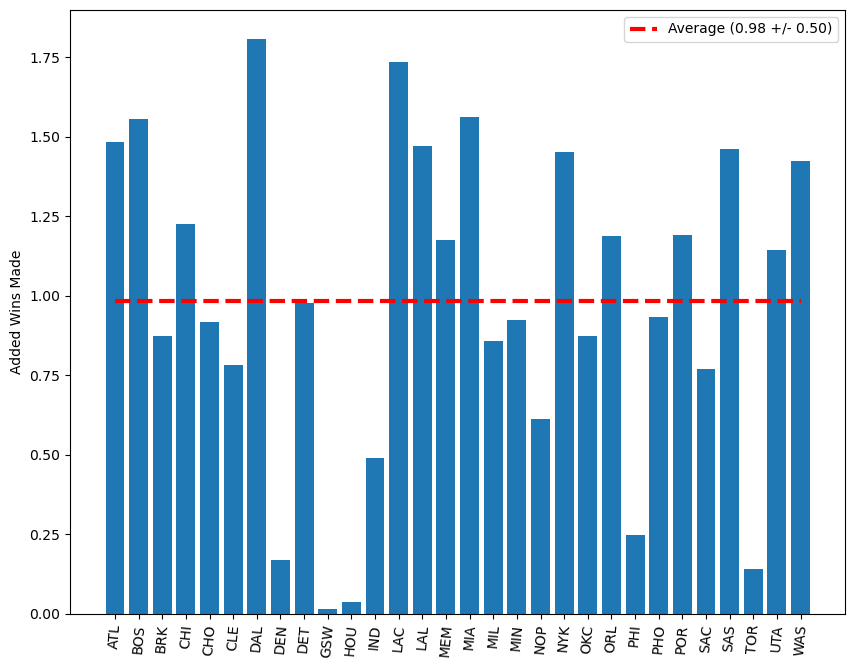

In [14]:
# Create a plot from this!
plt.figure(figsize=(10,8), dpi=100)
labels = resultsData.team.to_numpy()
heights = resultsData.addedWins.to_numpy()
avgHeight = np.mean(heights)
stdHeight = np.std(heights)

x = range(len(labels))
plt.bar(x, heights)
plt.plot([min(x), max(x)], [avgHeight, avgHeight], "--r", linewidth=3, 
         label="Average ({:.2f} +/- {:.2f})".format(avgHeight, stdHeight))
plt.legend()

plt.ylabel("Added Wins Made")
plt.xticks(x, labels, rotation=85)
plt.show()

In [15]:
# plot the average value
oldWMs = []
newWMs = []
for i in range(len(simData)):
    oldPlayer = simData["oldPick"].iloc[i]
    newPlayer = simData["newPick"].iloc[i]
    
    oldWM = scaledDraft[scaledDraft["Player"]==oldPlayer].iloc[0]["WM"]
    newWM = scaledDraft[scaledDraft["Player"]==newPlayer].iloc[0]["WM"]
    
    if pd.isnull(oldWM) or pd.isnull(newWM):
        continue
    
    oldWMs.append(oldWM)
    newWMs.append(newWM)

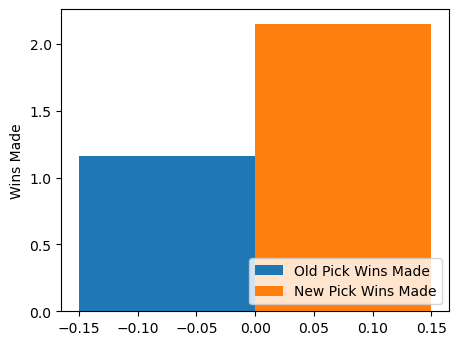

Old Average: 1.1599762035511623 New Average: 2.1509244005125385


In [16]:
plt.figure(figsize=(5,4), dpi=100)
width = 0.15       # the width of the bars
r1 = width/2.
r2 = -width/2.

plt.bar(r2, [np.mean(oldWMs)], width=width, label="Old Pick Wins Made")
plt.bar(r1, [np.mean(newWMs)], width=width, label="New Pick Wins Made")

plt.ylabel("Wins Made")

plt.legend(loc="lower right")
plt.show()
print("Old Average:", np.mean(oldWMs), "New Average:", np.mean(newWMs))

In [17]:
filenamevals = [str(i) for i in [1,2, "a", "b", 2.22]]
filename = '_'.join(filenamevals)+'.npy'

In [18]:
filename

'1_2_a_b_2.22.npy'